In [1]:
import shutil

# Copy your dataset to a writable folder
shutil.copytree("/kaggle/input/tsb111", "/kaggle/working/tsb111", dirs_exist_ok=True)

print("✅ Dataset copied to /kaggle/working/tsb111 — now you can modify it freely!")

✅ Dataset copied to /kaggle/working/tsb111 — now you can modify it freely!


In [2]:
import os

# ✅ Use the writable dataset path
base_dir = "/kaggle/working/tsb111"

train_images_dir = os.path.join(base_dir, "train", "images")
train_labels_dir = os.path.join(base_dir, "train", "labels")

aug_img_dir = os.path.join(train_images_dir, "augmented")
aug_lbl_dir = os.path.join(train_labels_dir, "augmented")

# ✅ Create folders safely
os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_lbl_dir, exist_ok=True)

print("✅ Augmentation folders created successfully!")
print("Images path:", aug_img_dir)
print("Labels path:", aug_lbl_dir)

✅ Augmentation folders created successfully!
Images path: /kaggle/working/tsb111/train/images/augmented
Labels path: /kaggle/working/tsb111/train/labels/augmented


In [3]:
import albumentations as A
import cv2
import os
import random
from tqdm import tqdm

# Set target number of images per class
TARGET = 80  

# Define augmentation pipeline
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.Blur(p=0.2),
    A.RandomScale(scale_limit=0.1, p=0.3)
])

# Paths
img_dir = os.path.join(base_dir, "train", "images")
lbl_dir = os.path.join(base_dir, "train", "labels")

aug_img_dir = os.path.join(img_dir, "augmented")
aug_lbl_dir = os.path.join(lbl_dir, "augmented")

# Get class counts
class_counts = {}
for label_file in os.listdir(lbl_dir):
    if not label_file.endswith(".txt"): continue
    with open(os.path.join(lbl_dir, label_file)) as f:
        for line in f:
            cls = int(line.split()[0])
            class_counts[cls] = class_counts.get(cls, 0) + 1

print("📊 Original class counts:", class_counts)

# Augment underrepresented classes
for cls, count in tqdm(class_counts.items(), desc="Augmenting classes"):
    if count >= TARGET:
        continue

    needed = TARGET - count
    created = 0

    for label_file in os.listdir(lbl_dir):
        if not label_file.endswith(".txt"):
            continue

        with open(os.path.join(lbl_dir, label_file)) as f:
            lines = f.readlines()
        if not any(int(l.split()[0]) == cls for l in lines):
            continue  # skip files without this class

        img_name = label_file.replace(".txt", ".jpg")
        img_path = os.path.join(img_dir, img_name)
        if not os.path.exists(img_path):
            continue

        image = cv2.imread(img_path)
        if image is None:
            continue

        while created < needed:
            aug = transform(image=image)
            aug_img = aug["image"]

            new_name = f"{cls}_aug_{created}_{img_name}"
            cv2.imwrite(os.path.join(aug_img_dir, new_name), aug_img)

            # Copy label file
            new_label = f"{cls}_aug_{created}_{label_file}"
            with open(os.path.join(aug_lbl_dir, new_label), "w") as f:
                f.writelines(lines)

            created += 1
            if created >= needed:
                break

print("✅ Dataset balanced successfully! Each class now has at least", TARGET, "images.")

📊 Original class counts: {11: 132, 50: 151, 36: 309, 24: 174, 49: 30, 34: 435, 25: 222, 32: 102, 26: 372, 20: 564, 8: 69, 15: 105, 22: 170, 1: 249, 7: 116, 4: 57, 40: 126, 35: 548, 29: 57, 3: 71, 27: 376, 54: 458, 37: 123, 0: 134, 39: 294, 52: 278, 38: 387, 45: 56, 41: 102, 30: 36, 17: 18, 5: 171, 18: 24, 6: 18, 48: 39, 13: 30, 31: 126, 33: 54, 55: 29, 23: 57, 14: 21, 12: 33, 10: 24, 53: 54, 21: 39, 43: 51, 44: 21, 42: 9, 2: 41, 16: 3, 28: 15, 19: 3, 47: 23, 9: 3, 51: 6, 46: 9}


Augmenting classes: 100%|██████████| 56/56 [00:12<00:00,  4.48it/s]

✅ Dataset balanced successfully! Each class now has at least 80 images.


In [4]:
import yaml

data = {
    "train": "/kaggle/working/tsb111/train/images",
    "val": "/kaggle/working/tsb111/valid/images",
    "test": "/kaggle/working/tsb111/test/images",
    "nc": 56,  # number of classes (update if different)
    "names": [str(i) for i in range(56)]  # or replace with your actual class names
}

yaml_path = "/kaggle/working/tsb111/data_balanced.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(data, f)

print("✅ data_balanced.yaml created at:", yaml_path)

✅ data_balanced.yaml created at: /kaggle/working/tsb111/data_balanced.yaml


In [5]:
!pip install ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.8 MB/s eta 0:00:0000:01


In [6]:
from ultralytics import YOLO

model = YOLO("/kaggle/input/ms0111/best (9).pt")  # or your custom model path

results = model.train(
    data="/kaggle/working/tsb111/data_balanced.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="traffic_sign_balanced"
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/tsb111/data_balanced.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        619        698      0.871      0.859      0.876      0.818
                     0         15         15      0.904      0.933      0.983      0.968
                     1         18         18      0.733      0.833      0.892      0.848
                     2          4          4      0.892          1      0.995      0.924
                     3          9          9      0.428      0.585      0.503      0.451
                     4         10         10      0.352        0.3      0.351       0.33
                     5         20         20      0.858        0.8      0.884      0.856
                     6          4          4      0.962          1      0.995      0.937
                     7         10         10      0.734        0.8       0.84      0.711
                     8          5          5      0.899        0.8      0.938      0.905
                    11         20         20      0.969          1      0.995      0.974
                    1

In [7]:
from ultralytics import YOLO

# Load the best trained model
model = YOLO("/kaggle/working/runs/detect/traffic_sign_balanced/weights/best.pt")


In [8]:
results = model.val(data="/kaggle/working/tsb111/data_balanced.yaml", split="val")


Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,016,568 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 626.4±121.9 MB/s, size: 41.8 KB)
val: Scanning /kaggle/working/tsb111/valid/labels.cache... 619 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 619/619 1.4Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 39/39 8.0it/s 4.9s<0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        619        698      0.873      0.859      0.876      0.817
                     0         15         15      0.905      0.933      0.983      0.968
                     1         18         18      0.734      0.833      0.898      0.854
                     2          4          4      0.894          1      0.995      0.924
                     3          9          9      0.427      0.582      0.503      0.453
                     4         10         10      0.353        0.3      0.351       0.33
                     5         20         20       0.86        0.8      0.884      0.854
                     6          4          4      0.963          1      0.995      0.961
                     7         10         10      0.741        0.8      0.838       0.71
                     8          5          5        0.9        0.8      0.938      0.905
                    11         20         20       0.97          1      0.995      0.974
                    1

In [9]:
print("\n📊 YOLOv8 Validation Summary")
print(f"Precision     : {results.box.p.mean():.3f}")
print(f"Recall        : {results.box.r.mean():.3f}")
print(f"mAP50         : {results.box.map50:.3f}")
print(f"mAP50-95      : {results.box.map:.3f}")



📊 YOLOv8 Validation Summary
Precision     : 0.873
Recall        : 0.859
mAP50         : 0.876
mAP50-95      : 0.817


In [10]:
import yaml

original_yaml = "/kaggle/input/tsb111/data.yaml"
balanced_yaml = "/kaggle/working/tsb111/data_balanced.yaml"

# Load both
with open(original_yaml, "r") as f:
    original = yaml.safe_load(f)

with open(balanced_yaml, "r") as f:
    balanced = yaml.safe_load(f)

# Copy class names
balanced["names"] = original["names"]

# Save back
with open(balanced_yaml, "w") as f:
    yaml.dump(balanced, f)

print("✅ Class names added successfully to data_balanced.yaml!")

✅ Class names added successfully to data_balanced.yaml!


In [11]:
with open(balanced_yaml, "r") as f:
    data = yaml.safe_load(f)

for i, name in enumerate(data["names"]):
    print(f"{i}: {name}")

0: Bicycles-crossing
1: Children-crossing
2: Danger-Ahead
3: Dangerous-curve-to-the-left
4: Dangerous-curve-to-the-right
5: Dont-Go-Left
6: Dont-Go-Left-or-Right
7: Dont-Go-Right
8: Dont-Go-straight
9: Dont-Go-straight-or-Right
10: Dont-Go-straight-or-left
11: Dont-overtake-from-Left
12: Give-Way
13: Go-Left
14: Go-Left-or-right
15: Go-Right
16: Go-left-or-straight
17: Go-right-or-straight
18: Go-straight
19: Go-straight-or-right
20: Green
21: Horn
22: No-Car
23: No-Uturn
24: No-entry
25: No-horn
26: No-stopping
27: Red
28: Road-Divider
29: Roundabout-mandatory
30: Side-Road-Left
31: Side-Road-Right
32: Speed-limit-100km-h-
33: Speed-limit-15km-h-
34: Speed-limit-30km-h-
35: Speed-limit-40km-h-
36: Speed-limit-50km-h-
37: Speed-limit-5km-h-
38: Speed-limit-60km-h-
39: Speed-limit-70km-h-
40: Speed-limit-90km-h-
41: Stop
42: Traffic-signals
43: Train-Crossing
44: Under-Construction
45: Uturn
46: Yellow
47: Zebra-Crossing
48: ZigZag-Curve
49: bump-ahead
50: cars-only
51: keep-Left
52: ke


image 1/308 /kaggle/input/tsb111/test/images/000030_jpg.rf.d57780d9721b654fbee9c01e93664c03.jpg: 640x640 1 1, 1 34, 6.8ms
image 2/308 /kaggle/input/tsb111/test/images/000032_jpg.rf.1136d3df21509e21895196c16e4d89c8.jpg: 640x640 1 34, 6.0ms
image 3/308 /kaggle/input/tsb111/test/images/000033_jpg.rf.7fb75c61487a6f7bfae68c0a979ffb45.jpg: 640x640 1 34, 5.8ms
image 4/308 /kaggle/input/tsb111/test/images/000066_jpg.rf.7c2e92842493886ae82291916d601026.jpg: 640x640 1 34, 5.9ms
image 5/308 /kaggle/input/tsb111/test/images/000074_jpg.rf.3fb353d0069dabf99b01ce2c1f9e18e2.jpg: 640x640 1 34, 6.1ms
image 6/308 /kaggle/input/tsb111/test/images/000103_jpg.rf.5daad80f93b24d328c8799bc7b3d8704.jpg: 640x640 1 36, 5.7ms
image 7/308 /kaggle/input/tsb111/test/images/000108_jpg.rf.88bbb7d87167647bc1d375eff9ef1676.jpg: 640x640 1 36, 5.7ms
image 8/308 /kaggle/input/tsb111/test/images/000114_jpg.rf.3ad4f7ba6783a736373bb2186ec9bee2.jpg: 640x640 1 38, 5.8ms
image 9/308 /kaggle/input/tsb111/test/images/000128_jpg.rf

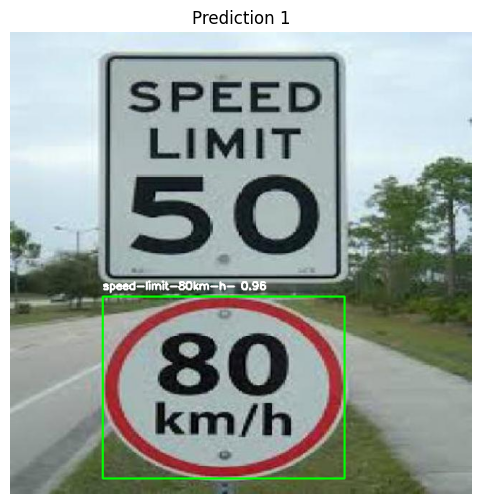

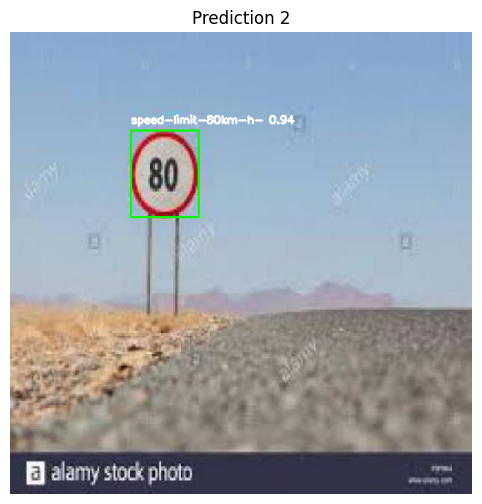

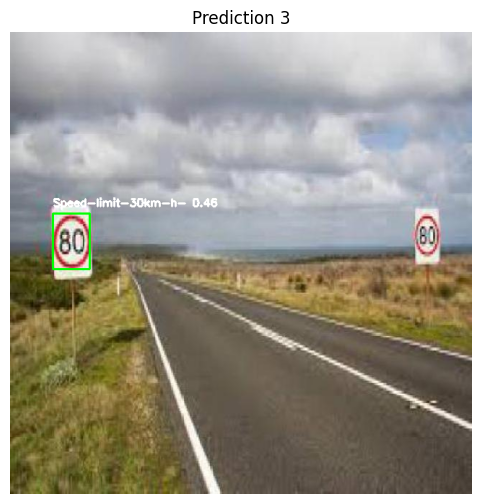

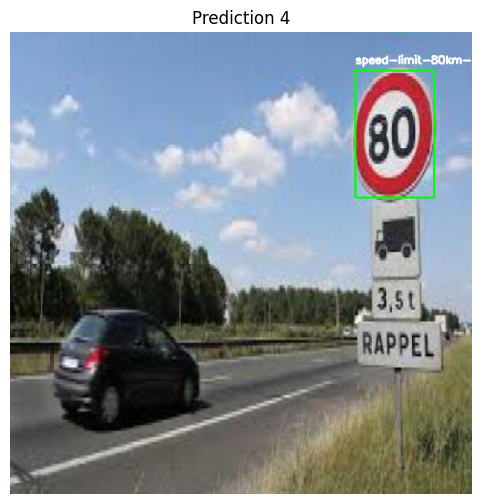

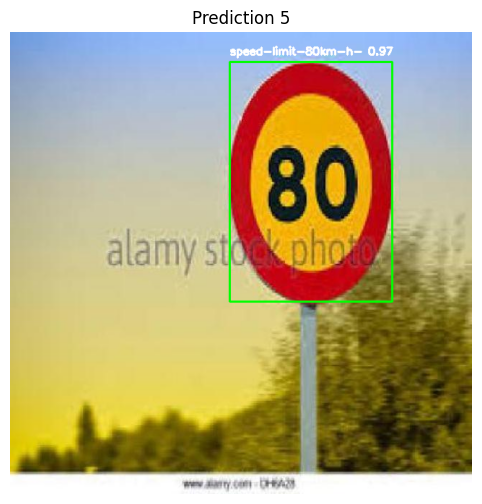

In [15]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# Define class names
class_names = ['Bicycles-crossing', 'Children-crossing', 'Danger-Ahead', 'Dangerous-curve-to-the-left',
'Dangerous-curve-to-the-right', 'Dont-Go-Left', 'Dont-Go-Left-or-Right', 'Dont-Go-Right',
'Dont-Go-straight', 'Dont-Go-straight-or-Right', 'Dont-Go-straight-or-left', 'Dont-overtake-from-Left',
'Give-Way', 'Go-Left', 'Go-Left-or-right', 'Go-Right', 'Go-left-or-straight', 'Go-right-or-straight',
'Go-straight', 'Go-straight-or-right', 'Green', 'Horn', 'No-Car', 'No-Uturn', 'No-entry', 'No-horn',
'No-stopping', 'Red', 'Road-Divider', 'Roundabout-mandatory', 'Side-Road-Left', 'Side-Road-Right',
'Speed-limit-100km-h-', 'Speed-limit-15km-h-', 'Speed-limit-30km-h-', 'Speed-limit-40km-h-',
'Speed-limit-50km-h-', 'Speed-limit-5km-h-', 'Speed-limit-60km-h-', 'Speed-limit-70km-h-',
'Speed-limit-90km-h-', 'Stop', 'Traffic-signals', 'Train-Crossing', 'Under-Construction', 'Uturn',
'Yellow', 'Zebra-Crossing', 'ZigZag-Curve', 'bump-ahead', 'cars-only', 'keep-Left', 'keep-Right',
'speed-limit-120km-h-', 'speed-limit-80km-h-', 'watch-out-for-cars']

# Load model
model = YOLO("/kaggle/working/runs/detect/traffic_sign_balanced/weights/best.pt")

# Run prediction on one image (you can replace with your own test image path)
test_img_path = "/kaggle/input/tsb111/test/images"  # folder or single image
results = model.predict(source=test_img_path, conf=0.4)

# Visualize first few predictions with class names
for i, r in enumerate(results[45:50]):  # show first 5 images
    img = cv2.imread(r.path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = r.boxes.xyxy.cpu().numpy()
    class_ids = r.boxes.cls.cpu().numpy().astype(int)
    confs = r.boxes.conf.cpu().numpy()

    for box, cls, conf in zip(boxes, class_ids, confs):
        x1, y1, x2, y2 = map(int, box)
        label = f"{class_names[cls]} {conf:.2f}"

        # Draw box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction {i+1}")
    plt.show()


image 1/1 /kaggle/input/tsb111/test/images/026_0045_png.rf.8dc5ad5d6eb8e7776405ae84eb41ff60.jpg: 640x640 1 52, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


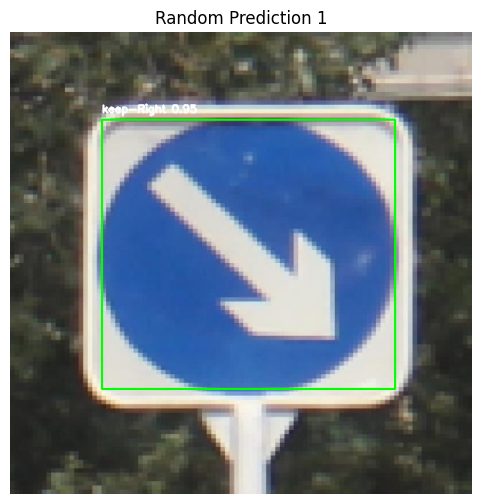


image 1/1 /kaggle/input/tsb111/test/images/000532_jpg.rf.bc4f6c6e2d33fc3abb5e71f824c0d2ba.jpg: 640x640 1 39, 6.5ms
Speed: 1.4ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


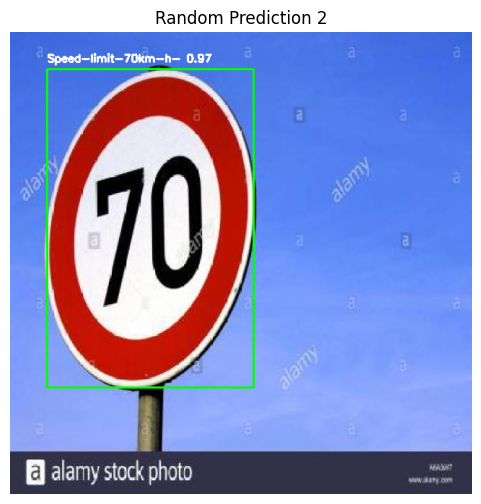


image 1/1 /kaggle/input/tsb111/test/images/000672_jpg.rf.a8d86985b128f50be325affeb2d217fc.jpg: 640x640 1 54, 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


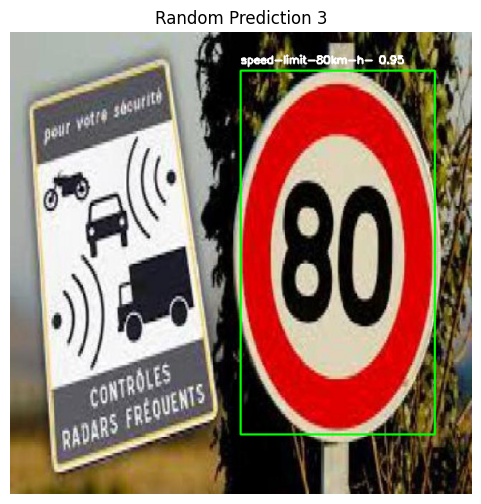


image 1/1 /kaggle/input/tsb111/test/images/044_0011_j_png.rf.f3a679fca0ff118b5b941399ee2dcddd.jpg: 640x640 1 31, 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


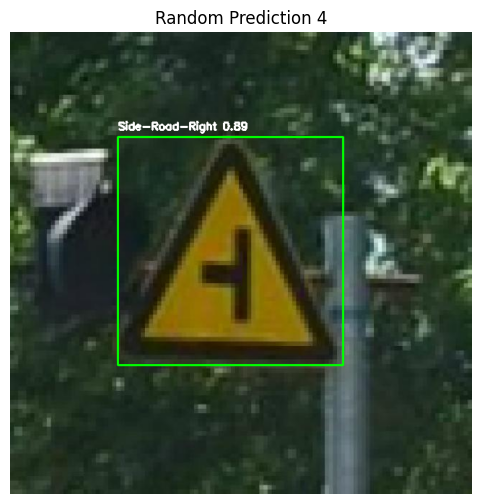


image 1/1 /kaggle/input/tsb111/test/images/031_0016_png.rf.cc8129722fed4de3e2b478d09e57866e.jpg: 640x640 1 45, 6.4ms
Speed: 1.4ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


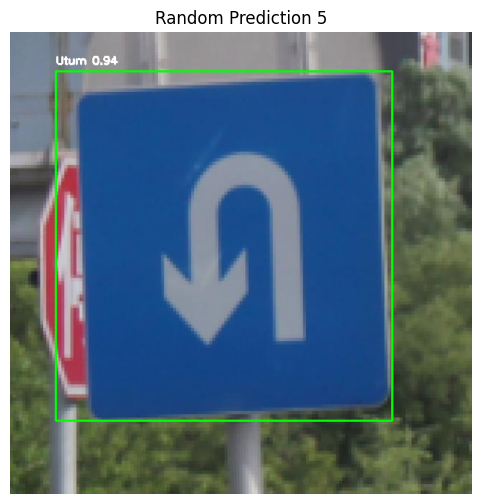

In [16]:
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path

# Load model
model = YOLO("/kaggle/working/runs/detect/traffic_sign_balanced/weights/best.pt")

# Define your class names
class_names = ['Bicycles-crossing', 'Children-crossing', 'Danger-Ahead', 'Dangerous-curve-to-the-left',
'Dangerous-curve-to-the-right', 'Dont-Go-Left', 'Dont-Go-Left-or-Right', 'Dont-Go-Right',
'Dont-Go-straight', 'Dont-Go-straight-or-Right', 'Dont-Go-straight-or-left', 'Dont-overtake-from-Left',
'Give-Way', 'Go-Left', 'Go-Left-or-right', 'Go-Right', 'Go-left-or-straight', 'Go-right-or-straight',
'Go-straight', 'Go-straight-or-right', 'Green', 'Horn', 'No-Car', 'No-Uturn', 'No-entry', 'No-horn',
'No-stopping', 'Red', 'Road-Divider', 'Roundabout-mandatory', 'Side-Road-Left', 'Side-Road-Right',
'Speed-limit-100km-h-', 'Speed-limit-15km-h-', 'Speed-limit-30km-h-', 'Speed-limit-40km-h-',
'Speed-limit-50km-h-', 'Speed-limit-5km-h-', 'Speed-limit-60km-h-', 'Speed-limit-70km-h-',
'Speed-limit-90km-h-', 'Stop', 'Traffic-signals', 'Train-Crossing', 'Under-Construction', 'Uturn',
'Yellow', 'Zebra-Crossing', 'ZigZag-Curve', 'bump-ahead', 'cars-only', 'keep-Left', 'keep-Right',
'speed-limit-120km-h-', 'speed-limit-80km-h-', 'watch-out-for-cars']

# Path to test images
test_dir = Path("/kaggle/input/tsb111/test/images")

# Pick 5 random images
test_images = random.sample(list(test_dir.glob("*.jpg")), 5)  # change .jpg to .png if needed

# Predict and show results
for i, img_path in enumerate(test_images):
    results = model.predict(source=str(img_path), conf=0.4)
    r = results[0]

    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = r.boxes.xyxy.cpu().numpy()
    class_ids = r.boxes.cls.cpu().numpy().astype(int)
    confs = r.boxes.conf.cpu().numpy()

    for box, cls, conf in zip(boxes, class_ids, confs):
        x1, y1, x2, y2 = map(int, box)
        label = f"{class_names[cls]} {conf:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    plt.figure(figsize=(7, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Random Prediction {i+1}")
    plt.show()

In [17]:
!pip install -q ultralytics albumentations opencv-python-headless --no-deps

In [19]:
import albumentations as A
import os

MODEL_PATH = "/kaggle/working/runs/detect/traffic_sign_balanced/weights/best.pt"  # same base model
DATA_PATH = "/kaggle/input/tsb111/data.yaml"     # dataset for albumentation training
EPOCHS = 20
IMAGE_SIZE = 640

train_transforms = A.Compose([
    A.OneOf([
        A.RandomRain(p=0.5),
        A.RandomFog(p=0.5),
        A.RandomSnow(p=0.5)
    ], p=0.8),
    A.RandomBrightnessContrast(p=0.3),
    A.MotionBlur(p=0.2),
    A.HueSaturationValue(p=0.3)
])

model = YOLO(MODEL_PATH)
print(f"Loaded pretrained model from: {MODEL_PATH}")

alb_results = model.train(
    data=DATA_PATH,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=16,
    name="YOLOv8_AdverseAug_Retrain",
    project="/kaggle/working",
    augment=True,
    degrees=0.0,
    translate=0.0,
    scale=0.0,
    shear=0.0,
    flipud=0.0,
    fliplr=0.0,
    mosaic=0.0,
    mixup=0.0,
    cache=False,
)

print("✅ Retraining complete with Albumentations (Rain, Fog, Snow) for 20 epochs.")
print("New model saved in:", alb_results.save_dir)

Loaded pretrained model from: /kaggle/working/runs/detect/traffic_sign_balanced/weights/best.pt
Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/tsb111/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/runs/detect/traffic_sign_balanced/weights/best.pt, momentum=0.937, mosaic=0.0

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        619        698      0.847      0.844       0.88      0.811
     Bicycles-crossing         15         15      0.913      0.933       0.96      0.929
     Children-crossing         18         18      0.751      0.833      0.894      0.855
          Danger-Ahead          4          4          1      0.864      0.995       0.96
Dangerous-curve-to-the-left          9          9      0.494      0.868      0.531      0.496
Dangerous-curve-to-the-right         10         10      0.349      0.216       0.55      0.505
          Dont-Go-Left         20         20      0.757        0.8      0.887      0.834
 Dont-Go-Left-or-Right          4          4          1      0.831      0.995      0.954
         Dont-Go-Right         10         10      0.724        0.7      0.735       0.67
      Dont-Go-straight          5          5          1      0.871      0.995      0.978
Dont-overtake-from-Left         20         20      0.985          1      0.995      0.956
         

✅ Loaded model from: /kaggle/working/YOLOv8_AdverseAug_Retrain2/weights/best.pt


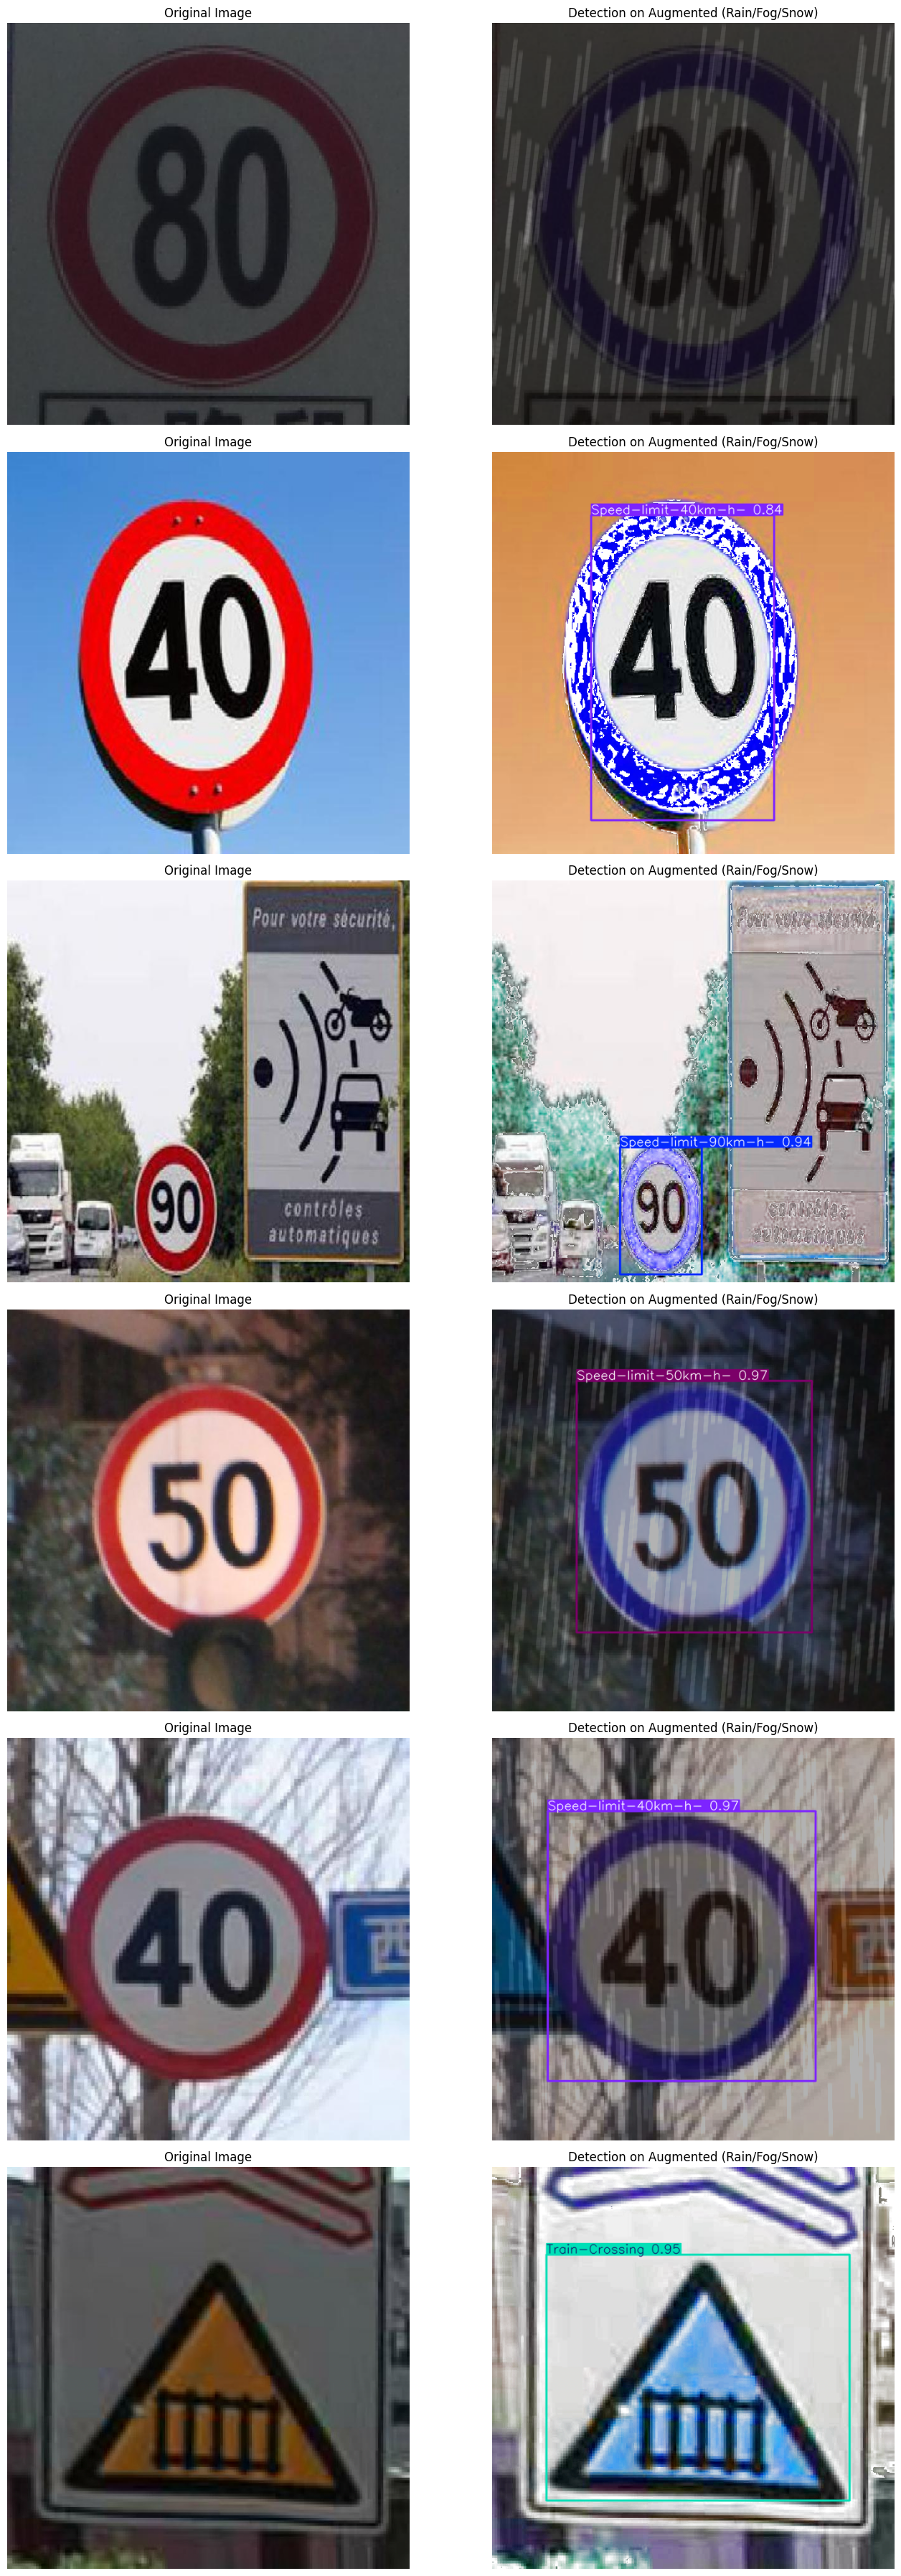

In [21]:
!pip install -q albumentations opencv-python-headless matplotlib --no-deps

import cv2, random, matplotlib.pyplot as plt

MODEL_PATH = "/kaggle/working/YOLOv8_AdverseAug_Retrain2/weights/best.pt"
TEST_DIR = "/kaggle/input/tsb111/test/images"
NUM_SAMPLES = 6
CONF_THR = 0.25

augment = A.Compose([
    A.OneOf([
        A.RandomRain(p=0.5),
        A.RandomFog(p=0.5),
        A.RandomSnow(p=0.5),
    ], p=1.0)
])

# Load the retrained model
model = YOLO(MODEL_PATH)
print(f"✅ Loaded model from: {MODEL_PATH}")

test_images = [f for f in os.listdir(TEST_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_imgs = random.sample(test_images, min(NUM_SAMPLES, len(test_images)))

plt.figure(figsize=(15, 6 * len(sample_imgs)))

for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(TEST_DIR, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    aug_img = augment(image=img)['image']
    results = model.predict(source=aug_img, conf=CONF_THR, verbose=False)
    res = results[0]
    img_pred = res.plot()

    plt.subplot(len(sample_imgs), 2, 2*i + 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(len(sample_imgs), 2, 2*i + 2)
    plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
    plt.title("Detection on Augmented (Rain/Fog/Snow)")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [25]:
# ==========================================================
# 5️⃣ Generate Detection Report for Albumentations Model
# ==========================================================
from ultralytics import YOLO
import IPython.display as display
from PIL import Image

# Load the retrained model
alb_report_model = YOLO("/kaggle/working/YOLOv8_AdverseAug_Retrain2/weights/best.pt")

# Run validation to get detection metrics
alb_val_results = alb_report_model.val(data="/kaggle/input/tsb111/data.yaml", split="val")

# Print key performance metrics
print("\n🌧️ YOLOv8 Validation Summary (Albumentations Retrained Model)")
print(f"Precision     : {alb_val_results.box.p.mean():.3f}")
print(f"Recall        : {alb_val_results.box.r.mean():.3f}")
print(f"mAP50         : {alb_val_results.box.map50:.3f}")
print(f"mAP50-95      : {alb_val_results.box.map:.3f}")

# Save text report
with open("/kaggle/working/albumentation_training_report.txt", "w") as f:
    f.write("🌧️ YOLOv8 Detection Report (Albumentations Retrained Model)\n")
    f.write(f"Precision : {alb_val_results.box.p.mean():.3f}\n")
    f.write(f"Recall    : {alb_val_results.box.r.mean():.3f}\n")
    f.write(f"mAP50     : {alb_val_results.box.map50:.3f}\n")
    f.write(f"mAP50-95  : {alb_val_results.box.map:.3f}\n")

print("✅ Albumentations training report saved to /kaggle/working/albumentation_training_report.txt")



Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,016,568 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 97.9±56.7 MB/s, size: 46.7 KB)
val: Scanning /kaggle/input/tsb111/valid/labels... 619 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 619/619 997.6it/s 0.6s0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/tsb111/valid is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 39/39 7.7it/s 5.0s<0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        619        698      0.832      0.893      0.887      0.827
     Bicycles-crossing         15         15       0.89      0.933      0.985      0.951
     Children-crossing         18         18       0.73      0.889      0.853      0.818
          Danger-Ahead          4          4          1      0.938      0.995      0.967
Dangerous-curve-to-the-left          9          9       0.48      0.889      0.519      0.487
Dangerous-curve-to-the-right         10         10      0.504        0.3      0.555       0.51
          Dont-Go-Left         20         20      0.728        0.8      0.886      0.849
 Dont-Go-Left-or-Right          4          4          1      0.893      0.995      0.962
         Dont-Go-Right         10         10      0.612        0.6      0.696      0.609
      Dont-Go-straight          5          5       0.86        0.8      0.855      0.855
Dont-overtake-from-Left         20         20      0.968          1      0.995      0.953
         

In [27]:
# ==========================================================
# 🟩 Re-load Normal Model Validation Results
# ==========================================================
from ultralytics import YOLO

# Path to your normal (non-augmented) trained model
normal_model = YOLO("/kaggle/working/runs/detect/traffic_sign_balanced/weights/best.pt")

# Validate it again to get metrics
val_results = normal_model.val(data="/kaggle/working/tsb111/data_balanced.yaml", split="val")

print("✅ Normal model metrics loaded for comparison.")


Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,016,568 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1268.0±274.7 MB/s, size: 34.7 KB)
val: Scanning /kaggle/working/tsb111/valid/labels.cache... 619 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 619/619 936.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 39/39 7.7it/s 5.0s<0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        619        698      0.873      0.859      0.876      0.817
                     0         15         15      0.905      0.933      0.983      0.968
                     1         18         18      0.734      0.833      0.898      0.854
                     2          4          4      0.894          1      0.995      0.924
                     3          9          9      0.427      0.582      0.503      0.453
                     4         10         10      0.353        0.3      0.351       0.33
                     5         20         20       0.86        0.8      0.884      0.854
                     6          4          4      0.963          1      0.995      0.961
                     7         10         10      0.741        0.8      0.838       0.71
                     8          5          5        0.9        0.8      0.938      0.905
                    11         20         20       0.97          1      0.995      0.974
                    1

In [28]:
# ==========================================================
# 📈 COMPARISON (Normal vs. Albumentations)
# ==========================================================
print("\n📈 COMPARISON (Normal vs. Albumentations)")
print(f"{'Metric':<12} {'Normal':>10} {'Albumented':>14}")
print(f"{'-'*40}")
print(f"Precision     {val_results.box.p.mean():>10.3f} {alb_val_results.box.p.mean():>14.3f}")
print(f"Recall        {val_results.box.r.mean():>10.3f} {alb_val_results.box.r.mean():>14.3f}")
print(f"mAP50         {val_results.box.map50:>10.3f} {alb_val_results.box.map50:>14.3f}")
print(f"mAP50-95      {val_results.box.map:>10.3f} {alb_val_results.box.map:>14.3f}")



📈 COMPARISON (Normal vs. Albumentations)
Metric           Normal     Albumented
----------------------------------------
Precision          0.873          0.832
Recall             0.859          0.893
mAP50              0.876          0.887
mAP50-95           0.817          0.827
